# Active Learning on Logistic Regression
## Configuration

In [1]:
# Config
"""
Set to a number to generate same split
Number of Iteration: number of iteraton of active learning
Number of Query: number of queries for to extract samples near to decision boundary
"""

random_state=0
number_of_iteration=10
number_of_query = 10

N_THRESHOLD = 1

## Active Learning Helper
### least_confident

1. Get probability of test data by calling `predict_proba`, return 2d vectors [0_probability, 1_probability]
2. For each vector, get max value of 2 probability values and negate the number to generate score. Higher score means higher uncertainty 
3. Get top N data.


In [2]:
# Active Learning Helper
# From https://github.com/davefernig/alp/
from __future__ import unicode_literals, division

from scipy.sparse import csc_matrix, vstack
from scipy.stats import entropy
from collections import Counter
import numpy as np

class ActiveLearner(object):
    _uncertainty_sampling_frameworks = [
        'entropy',
        'max_margin',
        'least_confident',
    ]

    _query_by_committee_frameworks = [
        'vote_entropy',
        'average_kl_divergence',
    ]

    def __init__(self, strategy='least_confident'):
        self.strategy = strategy

    def rank(self, clf, X_unlabeled, num_queries=None):
        if num_queries == None:
            num_queries = X_unlabeled.shape[0]

        elif type(num_queries) == float:
            num_queries = int(num_queries * X_unlabeled.shape[0])

        if self.strategy in self._uncertainty_sampling_frameworks:
            scores = self.__uncertainty_sampling(clf, X_unlabeled)

        elif self.strategy in self._query_by_committee_frameworks:
            scores = self.__query_by_committee(clf, X_unlabeled)

        else: 
            raise ValueError(
                "No input strategy"
            )
        rankings = np.argsort(-scores)[:num_queries]
        return rankings

    def __uncertainty_sampling(self, clf, X_unlabeled):
        probs = clf.predict_proba(X_unlabeled)

        if self.strategy == 'least_confident':
            return 1 - np.amax(probs, axis=1)

        elif self.strategy == 'max_margin':
            margin = np.partition(-probs, 1, axis=1)
            return -np.abs(margin[:,0] - margin[:, 1])

        elif self.strategy == 'entropy':
            return np.apply_along_axis(entropy, 1, probs)

    def __query_by_committee(self, clf, X_unlabeled):
        num_classes = len(clf[0].classes_)
        C = len(clf)
        preds = []

        if self.strategy == 'vote_entropy':
            for model in clf:
                y_out = map(int, model.predict(X_unlabeled))
                preds.append(np.eye(num_classes)[y_out])

            votes = np.apply_along_axis(np.sum, 0, np.stack(preds)) / C
            return np.apply_along_axis(entropy, 1, votes)

        elif self.strategy == 'average_kl_divergence':
            for model in clf:
                preds.append(model.predict_proba(X_unlabeled))

            consensus = np.mean(np.stack(preds), axis=0)
            divergence = []
            for y_out in preds:
                divergence.append(entropy(consensus.T, y_out.T))
            
            return np.apply_along_axis(np.mean, 0, np.stack(divergence))

In [3]:
import numpy as np
import sklearn
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# metrics
from sklearn.metrics import precision_recall_curve
# plot
import matplotlib.pyplot as plt
%matplotlib inline

# Initialization
active_learner = ActiveLearner("least_confident")
precisions = []
recalls = []

#Load Data
path = "data/"
y = np.array([])
T1 = np.loadtxt(path+"hurricane.vec")
T = T1
y = np.append(y, np.ones(len(T)))
F1 = np.loadtxt(path+"lasvegas.vec")
F2 = np.loadtxt(path+"false.vec")
F = np.append(F1, F2, axis=0)
y = np.append(y, np.zeros(len(F)))
embedding = np.append(T,F,axis=0)
X = sklearn.preprocessing.normalize(embedding)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
reg = sklearn.linear_model.LogisticRegressionCV()

# init state
reg.fit(X_train, y_train)
y_predict = reg.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
precisions.append(precision[N_THRESHOLD])
recalls.append(recall[N_THRESHOLD])
print("init")
print("@P:", precision)
print("@R:", recall)
print(thresholds)
print()

# Active Learning
for i in range(number_of_iteration):
    idx = active_learner.rank(reg, X_test, number_of_query)
    X_train = np.concatenate([X_train, X_test[idx, :]])
    y_train = np.concatenate([y_train, y_test[idx]])
    X_test = np.delete(X_test, idx, axis=0)
    y_test = np.delete(y_test, idx, axis=0)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    precisions.append(precision[N_THRESHOLD])
    recalls.append(recall[N_THRESHOLD])
    print("Active Learning Round: ", i+1)
    print("Train: ", len(X_train))
    print("Test: ", len(X_test))
    print("@P:", precision)
    print("@R:", recall)
    print(thresholds)
    print()

al_precision = precisions
al_recall = recalls

init
@P: [ 0.34801762  0.91525424  1.        ]
@R: [ 1.         0.6835443  0.       ]
[ 0.  1.]

Active Learning Round:  1
Train:  349
Test:  217
@P: [ 0.33640553  0.91071429  1.        ]
@R: [ 1.          0.69863014  0.        ]
[ 0.  1.]

Active Learning Round:  2
Train:  359
Test:  207
@P: [ 0.31884058  0.93877551  1.        ]
@R: [ 1.         0.6969697  0.       ]
[ 0.  1.]

Active Learning Round:  3
Train:  369
Test:  197
@P: [ 0.30964467  0.93877551  1.        ]
@R: [ 1.          0.75409836  0.        ]
[ 0.  1.]

Active Learning Round:  4
Train:  379
Test:  187
@P: [ 0.31016043  0.94        1.        ]
@R: [ 1.          0.81034483  0.        ]
[ 0.  1.]

Active Learning Round:  5
Train:  389
Test:  177
@P: [ 0.30508475  0.9375      1.        ]
@R: [ 1.          0.83333333  0.        ]
[ 0.  1.]

Active Learning Round:  6
Train:  399
Test:  167
@P: [ 0.2994012   0.93617021  1.        ]
@R: [ 1.    0.88  0.  ]
[ 0.  1.]

Active Learning Round:  7
Train:  409
Test:  157
@P: [ 0.305

In [4]:
# Control Group
import numpy as np
import sklearn
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# metrics
from sklearn.metrics import precision_recall_curve
# plot
import matplotlib.pyplot as plt
%matplotlib inline

# Initialization
active_learner = ActiveLearner("least_confident")
precisions = []
recalls = []

#Load Data
path = "data/"
y = np.array([])
T1 = np.loadtxt(path+"hurricane.vec")
T = T1
y = np.append(y, np.ones(len(T)))
F1 = np.loadtxt(path+"lasvegas.vec")
F2 = np.loadtxt(path+"false.vec")
F = np.append(F1, F2, axis=0)
y = np.append(y, np.zeros(len(F)))
embedding = np.append(T,F,axis=0)
X = sklearn.preprocessing.normalize(embedding)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
reg = sklearn.linear_model.LogisticRegressionCV()

# init state
reg.fit(X_train, y_train)
y_predict = reg.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
precisions.append(precision[N_THRESHOLD])
recalls.append(recall[N_THRESHOLD])
print("init")
print("@P:", precision)
print("@R:", recall)
print(thresholds)
print()

def random_chose(X_test, number_of_query):
    idx = np.arange(len(X_test))
    np.random.shuffle(idx)
    return idx[:number_of_query]

for i in range(number_of_iteration):
    idx = random_chose(X_test, number_of_query)
    X_train = np.concatenate([X_train, X_test[idx, :]])
    y_train = np.concatenate([y_train, y_test[idx]])
    X_test = np.delete(X_test, idx, axis=0)
    y_test = np.delete(y_test, idx, axis=0)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    precisions.append(precision[N_THRESHOLD])
    recalls.append(recall[N_THRESHOLD])
    print("Control Group Round: ", i+1)
    print("Train: ", len(X_train))
    print("Test: ", len(X_test))
    print("@P:", precision)
    print("@R:", recall)
    print(thresholds)
    print()

n_precision = precisions
n_recall = recalls

init
@P: [ 0.34801762  0.91525424  1.        ]
@R: [ 1.         0.6835443  0.       ]
[ 0.  1.]

Control Group Round:  1
Train:  349
Test:  217
@P: [ 0.35023041  0.90909091  1.        ]
@R: [ 1.          0.65789474  0.        ]
[ 0.  1.]

Control Group Round:  2
Train:  359
Test:  207
@P: [ 0.352657    0.88888889  1.        ]
@R: [ 1.          0.65753425  0.        ]
[ 0.  1.]

Control Group Round:  3
Train:  369
Test:  197
@P: [ 0.34517766  0.82539683  1.        ]
@R: [ 1.          0.76470588  0.        ]
[ 0.  1.]

Control Group Round:  4
Train:  379
Test:  187
@P: [ 0.35294118  0.9         1.        ]
@R: [ 1.          0.68181818  0.        ]
[ 0.  1.]

Control Group Round:  5
Train:  389
Test:  177
@P: [ 0.36723164  0.91304348  1.        ]
@R: [ 1.          0.64615385  0.        ]
[ 0.  1.]

Control Group Round:  6
Train:  399
Test:  167
@P: [ 0.36526946  0.90697674  1.        ]
@R: [ 1.          0.63934426  0.        ]
[ 0.  1.]

Control Group Round:  7
Train:  409
Test:  157
@P: 

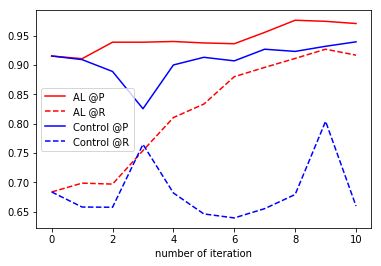

In [5]:
x = range(number_of_iteration + 1)
plt.xlabel("number of iteration")
p1, = plt.plot(x, al_precision, "r-", label="AL @P")
r1, = plt.plot(x, al_recall, "r--", label="AL @R")
p2, = plt.plot(x, n_precision, "b-", label="Control @P")
r2, = plt.plot(x, n_recall, "b--", label="Control @R")
plt.legend(handles=[p1, r1, p2, r2])